In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [17]:
df_classes = pd.read_csv("dataset/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("dataset/elliptic_txs_features.csv", header=None)

No. of transactions (nodes) = 203769, <br />
No. of bitcoin flows (edges) = 234355

In [18]:
df_classes['class'].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

Class 1 = Illicit, <br />
Class 2 = Licit

In [171]:
df_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [19]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


As the features data is anonymized, the colnames are not have proper naming. To derive from this columns: <br />
1. column_0 looks like transactionId
2. column_1 looks like timesteps for each node. timesteps have an interval of ~2 weeks. Each timestep contains connected component of transactions, which appeared on blockchin within <3 hours between eachother.

In [42]:
df_features.columns = ['txId', 'time_step'] + [f'local_feat_{i}' for i in range(1, 94)] + [f'aggr_feat_{i}' for i in range(1, 73)]

In [43]:
df_features.head()

,txId,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [44]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3

In [49]:
print("shape of classes dataframe: ", df_classes.shape)
print("shape of edgelist dataframe: ", df_edgelist.shape)
print("shape of features dataframe: ", df_features.shape)

shape of classes dataframe:  (203769, 2)
shape of edgelist dataframe:  (234355, 2)
shape of features dataframe:  (203769, 167)


### EDA

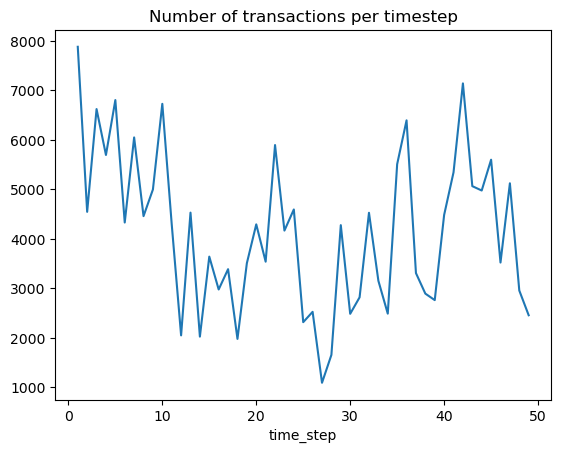

In [51]:
df_features['time_step'].value_counts().sort_index().plot()
plt.title('Number of transactions per timestep')
plt.show()

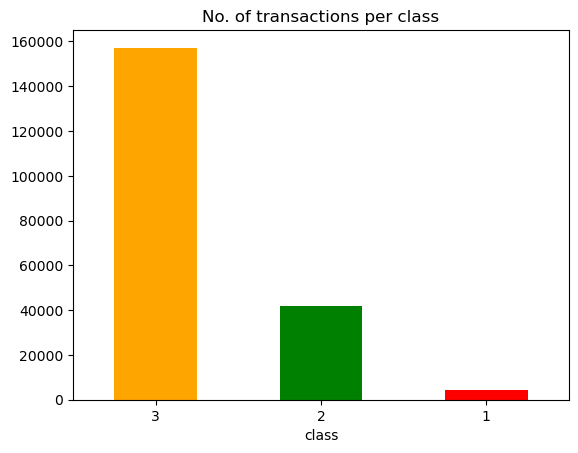

In [67]:
df_classes['class'].value_counts().plot(kind = 'bar', color = ['orange', 'green', 'red'])
plt.xticks(rotation = 0)
plt.title('No. of transactions per class')
plt.show()

In [85]:
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [90]:
group_class_feature = df_class_feature.groupby(['class', 'time_step'])['txId'].count().reset_index()
group_class_feature.columns = ['Class', 'Time Step', 'Transaction Count']
group_class_feature.head()

,Class,Time Step,Transaction Count
0,3,1,5733
1,3,2,3427
2,3,3,5342
3,3,4,4253
4,3,5,4921


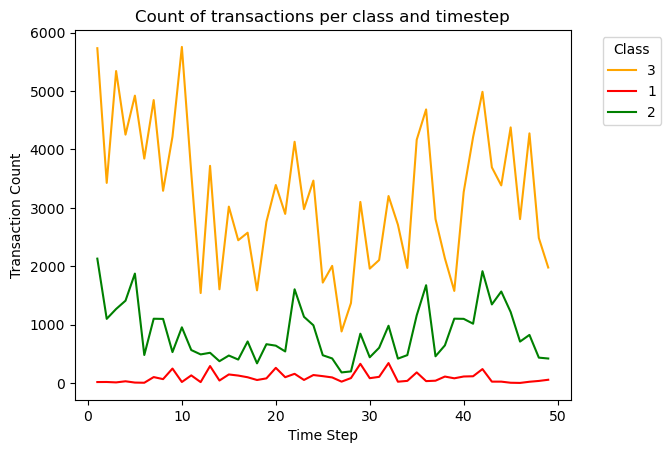

In [117]:
sns.lineplot(data = group_class_feature, x = 'Time Step', y = 'Transaction Count', hue = 'Class', palette = ['orange',
    'red', 'green'])
plt.title('Count of transactions per class and timestep')
plt.legend(title = 'Class', bbox_to_anchor=(1.05, 1), loc = 2)
plt.show()

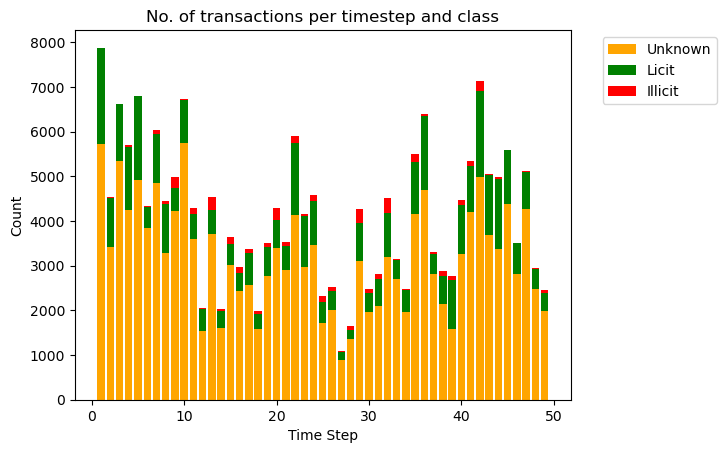

In [145]:
class1 = group_class_feature[group_class_feature['Class'] == '1']
class2 = group_class_feature[group_class_feature['Class'] == '2']
class3 = group_class_feature[group_class_feature['Class'] == 3]

p1 = plt.bar(class3['Time Step'], class3['Transaction Count'], color = 'orange')

p2 = plt.bar(class2['Time Step'], class2['Transaction Count'], color = 'green'
             , bottom = class3['Transaction Count'])

p3 = plt.bar(class1['Time Step'], class1['Transaction Count'], color = 'red'
             , bottom = np.array(class3['Transaction Count']) + np.array(class2['Transaction Count']))

plt.xlabel('Time Step')
plt.ylabel('Count')
plt.title('No. of transactions per timestep and class')
plt.legend(['Unknown', 'Licit', 'Illicit'], bbox_to_anchor = (1.05,1), loc = 2)
plt.show()

In [162]:
group_class_feature.groupby(['Class'])['Transaction Count'].max()

Class
3    5755
1     342
2    2130
Name: Transaction Count, dtype: int64

In [167]:
group_class_feature.loc[group_class_feature['Transaction Count'] == 342]

,Class,Time Step,Transaction Count
80,1,32,342


In [172]:
illicit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

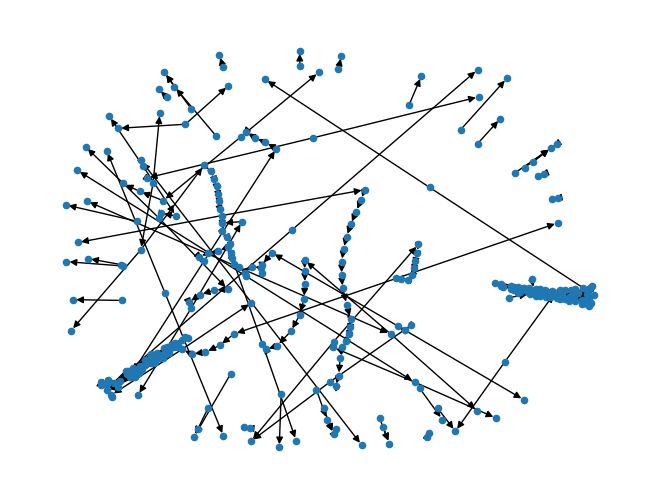

In [186]:
graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 20)

In [174]:
licit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(licit_ids)]

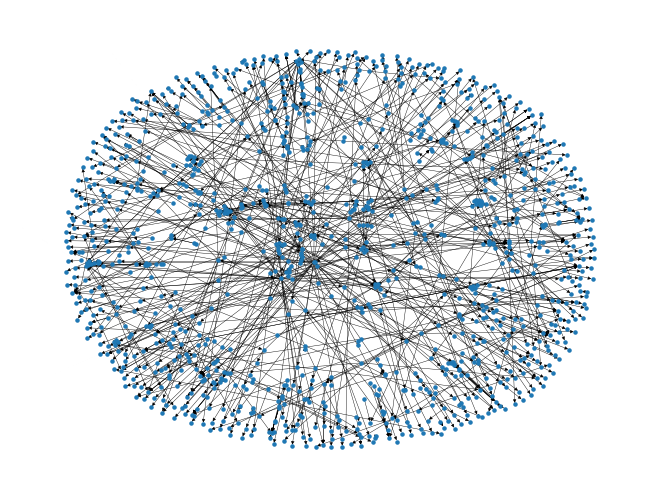

In [184]:
graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 5, width = 0.3, arrowsize = 5)